# Tutorial 1: Convolution - implementation and examples

## Definition

Given two singals $f\left(x\right)$ and $h\left(x\right)$, their convolutions is defined as
$$\left(h*f\right)\left(x\right)=\int h\left(x-y\right)f\left(y\right)dy$$

In the discrete case we define
$$\left(h*f\right)\left[n\right]=\sum_kh\left[n-k\right]f\left[k\right]$$

Although convolution is commutative, we will usually refer to $f$ as the signal and call $h$ the kernel or the filter.

## 1D convolution
Let's see a few examples:

![first example](./1d1.gif)

![second example](./1d2.gif)

Let's start coding. We will import a the required libraries.

In [1]:
import numpy as np
import scipy.signal
import cv2
from matplotlib import pyplot as plt

Below is a very primitive implementation of convolution on 1D. It implements the core functionality of the function `scipy.signal.convolve`. However this is a specific case where there is zero padding and the parameter `size='valid'`.

In [2]:
def my_conv1d(a, b):
    c = np.zeros(a.size + b.size - 1)
    for i in np.arange(a.size):
        for j in np.arange(b.size):
            c[i + j] += a[i] * b[j]
    
    return c

Let us see an example:
* Consider a constant signal with 100 sample points which is contaminated by additive gaussian noise.
* Consider a uniform filter which is initalized to ones and then normalized. We normalize our kernels just so that we end up with a similar range of values as in the original signal. Try playing with the value of `KERNEL_SIZE` and see what happens.

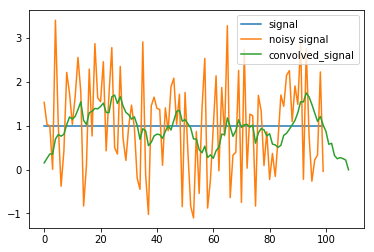

In [3]:
SIGNAL_SIZE = 100
KERNEL_SIZE = 10

signal = np.ones(SIGNAL_SIZE)
noise = np.random.randn(SIGNAL_SIZE)
noisy_signal = signal + noise
kernel = np.ones(KERNEL_SIZE)
kernel /= sum(kernel)
convolved_signal = my_conv1d(noisy_signal, kernel)

plt.plot(signal)
plt.plot(noisy_signal)
plt.plot(convolved_signal)
plt.legend(('signal', 'noisy signal', 'convolved_signal'))

## 2D convolution
![illustration](./2d.gif)

Now we will implement a primitive asymmetrical implementation of conv2d. Basically we go over each pixel, consider it's neighborhood and multiply element-wise with the kernel. This gives us the pixel value of the convolved image with the given kernel.

In [4]:
def my_conv2d(image, kernel, normalize=False):
    # fetch the dimensions for iteration over the pixels and weights
    image_height, image_width = image.shape[0], image.shape[1]
    kernel_height, kernel_width = kernel.shape[0], kernel.shape[1]
    kernel_shift_y = int(kernel_height / 2)
    kernel_shift_x = int(kernel_width / 2)

    # prepare the output array
    filtered = np.zeros_like(image)
    
    # iterate over each (x, y) pixel in the image
    for y in range(image_height):
        for x in range(image_width):
            weighted_pixel_sum = 0

            # Iterate over each weight at (kx, ky) in the kernel defined above ...
            # We interpret the kernel weights in a way that the 'central' weight is at (0, 0);
            # so the coordinates in the kernel are:
            #
            #  [ (-1,-1),  (0,-1),  (1,-1)
            #    (-1, 0),  (0, 0),  (1, 0)
            #    (-1, 1),  (0, 1),  (1, 1)
            #
            # This way, the pixel at image[y,x] is multiplied with the kernel[0,0]; analogous,
            # image[y-1,x] is multiplied with kernel[-1,0] etc.
            # The filtered pixel is then the sum of these, so that
            #
            #   weighted_pixel_sum = image[y-1,x-1] * kernel[-1,-1] +
            #                        image[y-1,x  ] * kernel[-1, 0] +
            #                        image[y-1,x+1] * kernel[-1, 1] +
            #                        image[y,  x-1] * kernel[ 0, 1] +
            #                        image[y,  x  ] * kernel[ 0, 0] +
            #                        etc.

            for ky in range(-kernel_shift_y, kernel_shift_y + 1):
                for kx in range(-kernel_shift_x, kernel_shift_x + 1):
                    pixel = 0
                    pixel_y = y - ky
                    pixel_x = x - kx

                    # boundary check: all values outside the image are treated as zero.
                    # this is a definition and implementation dependent
                    if (pixel_y >= 0) and (pixel_y < image_height) and (pixel_x >= 0) and (pixel_x < image_width):
                        pixel = image[pixel_y, pixel_x]

                    # get the weight at the current kernel position
                    # (also un-shift the kernel coordinates into the valid range for the array)
                    weight = kernel[ky + kernel_shift_y, kx + kernel_shift_x]

                    # weigh the pixel value and sum
                    weighted_pixel_sum += pixel * weight

            # finally, the pixel at location (x,y) is the sum of the weighed neighborhood
            filtered[y, x] = weighted_pixel_sum
            
    if normalize:
        filtered = filtered / kernel.sum()
        
    return filtered

Now we import an image using the cv2 package and scale it in the range [0,1]. 

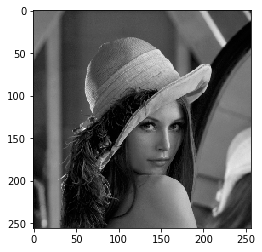

In [5]:
WHITE_LEVEL = 255

image = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE).astype(float)
image /= WHITE_LEVEL
image = cv2.resize(image, (256, 256, ))
plt.imshow(image, cmap='gray')
plt.show()

Let us use our implementation to do uniform blurring. Try playing with the kernel size.

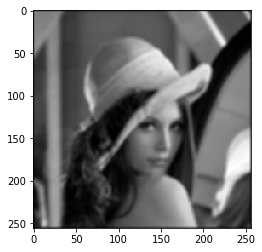

In [6]:
kernel = np.ones((5, 5))
filtered_image = my_conv2d(image, kernel, normalize=True)
plt.imshow(filtered_image, cmap='gray')
plt.show()

Now, let us see how our function behaves when convolving with an indicator function. Try playing with the indices of the chosen pixel.

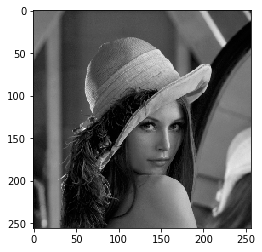

In [7]:
kernel = np.zeros((9, 9))
kernel[4, 4] = 1
filtered_image = my_conv2d(image, kernel, normalize=True)
plt.imshow(filtered_image, cmap='gray')
plt.show()

Note: the code we wrote isn't optimal, since it doesn't let you control the padding and it's also quite slow.

Convolutions can be implemented efficiently by constructing a sparse matrix using the kernel and then multiplying the signal with it.

Another efficient way to implment convolution is by using the "convolution theorem". As you have seen in the lecture, this theorem states that every convolution is just a point-wise multiplication in the Fourier domain. 

All the standard libraries in Python use such efficient implementations, so let us now use the convolution operation from our imported libraries.

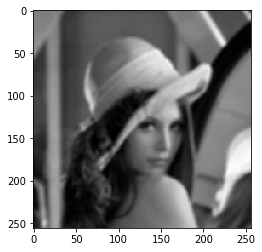

In [8]:
kernel = np.ones((5, 5))
kernel /= kernel.sum()
filtered_image = scipy.signal.convolve2d(image, kernel, boundary='symm', mode='same')
plt.imshow(filtered_image, cmap='gray')
plt.show()

Let us look at more realistic kernels, the Gaussian kernels:
$$h\left(x\right)=\exp\left(-x^TAx\right)$$
where $A$ is a PSD matrix.

We will usually assume that $A$ is diagonalizable and hence:
$$h\left(x\right)=\exp\left(-\sum_i\sigma_ix_i^2\right)$$

Here are a few examples (try playing with values of $\sigma_i$):

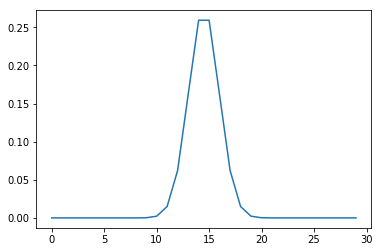

In [9]:
t = np.linspace(-10, 10, 30)
gauss_1d = np.exp(-0.5 * t ** 2)
gauss_1d /= np.sum(gauss_1d)
plt.plot(gauss_1d)

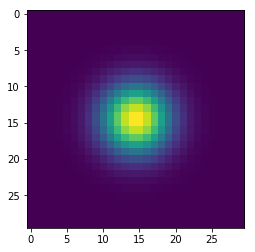

In [10]:
gauss_1d = np.exp(-0.1 * t ** 2)
gauss_2d_isotropic = np.outer(gauss_1d, gauss_1d)
plt.imshow(gauss_2d_isotropic)

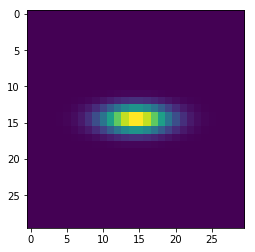

In [11]:
gauss_1d_x = np.exp(-0.1 * t ** 2)
gauss_1d_y = np.exp(-0.7 * t ** 2)
gauss_2d_anisotropic = np.outer(gauss_1d_y, gauss_1d_x)
plt.imshow(gauss_2d_anisotropic)

Let us compare what happens when we convolve with these kernels.

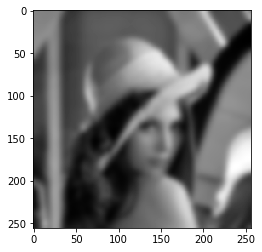

In [12]:
isotropic_filtered_image = scipy.signal.convolve2d(image, gauss_2d_isotropic, boundary='symm', mode='same')
plt.imshow(isotropic_filtered_image, cmap='gray')
plt.show()

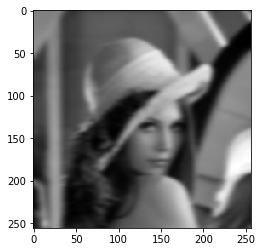

In [13]:
anisotropic_filtered_image = scipy.signal.convolve2d(image, gauss_2d_anisotropic, boundary='symm', mode='same')
plt.imshow(anisotropic_filtered_image, cmap='gray')
plt.show()

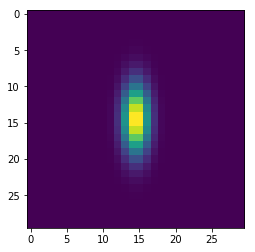

In [14]:
rotated_anisotropic_filter = np.transpose(gauss_2d_anisotropic)
plt.imshow(rotated_anisotropic_filter)
plt.show()

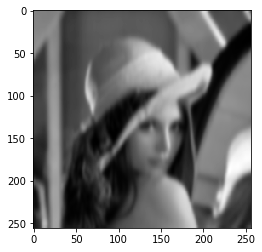

In [15]:
rotated_anisotropic_filtered_image = scipy.signal.convolve2d(image, rotated_anisotropic_filter, boundary='symm', mode='same')
plt.imshow(rotated_anisotropic_filtered_image, cmap='gray')
plt.show()

As of now, we have only seen the use of convolutions for blurring images, but we can also construct filters for sharpenning them as well.

We will start by using an edge detection filter. Convolving an image $ u(x,y) $ with it gives us a numerical estimation of the laplacian of the image $ \Delta u(x,y)=u_{xx}(x,y)+u_{yy}(x,y) $.

In [16]:
edge_detection_filter = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])

print(edge_detection_filter)

[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


Let's convolve with this filter.

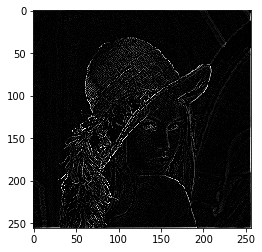

In [17]:
edges = scipy.signal.convolve2d(image, edge_detection_filter, mode='same')
edges = edges.clip(0, 1)
plt.imshow(edges ,cmap='gray')

Let's add the edges back to the original image to increase the sharpness. Try playing with the value of SHARPEN_FORCE.

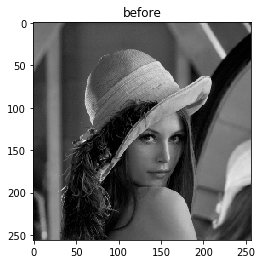

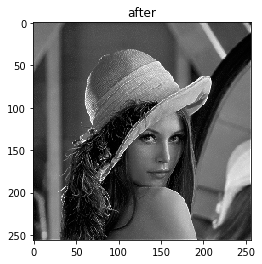

In [18]:
SHARPEN_FORCE = 0.3
sharpened_image = image + SHARPEN_FORCE * edges
sharpened_image = sharpened_image.clip(0, 1)

plt.imshow(image, cmap='gray')
plt.title('before')
plt.show()
plt.imshow(sharpened_image, cmap='gray')
plt.title('after')
plt.show()

We can also use the diagonal neighboring pixels for detecting edges.

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


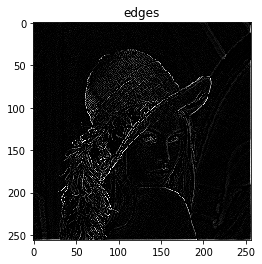

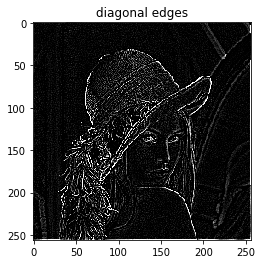

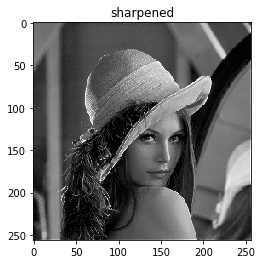

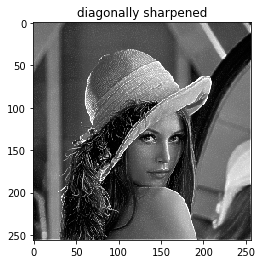

In [19]:
diagonal_edge_detection_filter = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

print(diagonal_edge_detection_filter)

diagonal_edges = scipy.signal.convolve2d(image, diagonal_edge_detection_filter, mode='same')
diagonal_edges = diagonal_edges.clip(0, 1)
plt.imshow(edges ,cmap='gray')
plt.title('edges')
plt.show()
plt.imshow(diagonal_edges ,cmap='gray')
plt.title('diagonal edges')
plt.show()

SHARPEN_FORCE = 0.3
diagonally_sharpened_image = image + SHARPEN_FORCE * diagonal_edges
diagonally_sharpened_image = diagonally_sharpened_image.clip(0, 1)

plt.imshow(sharpened_image, cmap='gray')
plt.title('sharpened')
plt.show()
plt.imshow(diagonally_sharpened_image, cmap='gray')
plt.title('diagonally sharpened')
plt.show()

Since convolutoin is a linear opration, we can also sharpen an image by using a single filter.

[1 1]
Edge detection filter:
[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]
Indicator filter:
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
Sharpen filter:
[[ 0.  -0.3  0. ]
 [-0.3  2.2 -0.3]
 [ 0.  -0.3  0. ]]


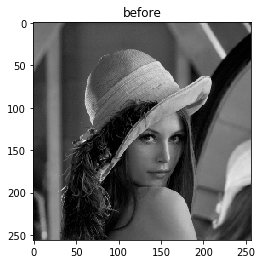

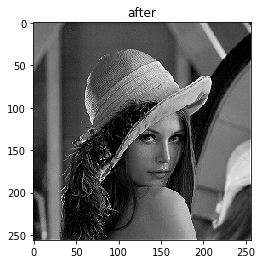

In [20]:
SHARPEN_FORCE = 0.3
indicator_filter = np.zeros(edge_detection_filter.shape)
print(np.array(edge_detection_filter.shape) // 2)
indicator_filter[1, 1] = 1
sharpen_filter = SHARPEN_FORCE * edge_detection_filter + indicator_filter

print('Edge detection filter:')
print(edge_detection_filter)
print('Indicator filter:')
print(indicator_filter)
print('Sharpen filter:')
print(sharpen_filter)

sharpened_image = scipy.signal.convolve2d(image, sharpen_filter, mode='same')
sharpened_image = sharpened_image.clip(0, 1)
plt.imshow(image, cmap='gray')
plt.title('before')
plt.show()
plt.imshow(sharpened_image, cmap='gray')
plt.title('after')
plt.show()

Previously we've constructed an anisotropic Gaussian kernel by multiplying two Gaussian kernels with different standard deviations, but realistic blur is not exactly Gaussian (it can be determined by the motion of the camera, for example).

Let us see a more general way of constructing kernels. We will use it for constructing Gaussians, but this can be trivially replaced by any other function of choice.

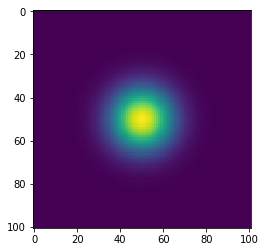

In [21]:
def gaussian_kernel(sample_range, sigma=1):
    """
    creates a gaussian kernel sampled between [-sample_range, sample_range] with a standard deviation of sigma
    """

    ax = np.arange(-sample_range, sample_range + 1)
    xx, yy = np.meshgrid(ax, ax)

    # 2d gaussian function in our case, but this can be any arbitrary function parametrized by x and y
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma **2))
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(50, sigma=10)
plt.imshow(kernel)
plt.show()